In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
cnt = 0
for dirname, _, filenames in os.walk('/kaggle/input/balloon/balloon/train'):
    for filename in filenames:
        cnt+=1
        #print(os.path.join(dirname, filename))
print ('train count',cnt)

cnt = 0
for dirname, _, filenames in os.walk('/kaggle/input/balloon/balloon/val'):
    for filename in filenames:
        cnt+=1
        #print(os.path.join(dirname, filename))
print ('val count',cnt)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#download balloon dataset zip

#https://github.com/matterport/Mask_RCNN/releases



In [6]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw



In [ ]:
# Root directory of the project
#ROOT_DIR = '/kaggle/working'

#!rm -rf Mask-RCNN-TF2/
#!git clone  https://github.com/ahmedfgad/Mask-RCNN-TF2.git
    
!rm -rf Mask_RCNN/
#!git clone https://github.com/matterport/Mask_RCNN.git
    
!git clone  https://github.com/akTwelve/Mask_RCNN 


In [ ]:
import tensorflow
tensorflow.__version__

In [7]:
# Root directory of the project
#ROOT_DIR = os.path.abspath('Mask-RCNN-TF2/')
ROOT_DIR = os.path.abspath('Mask_RCNN/')
print (ROOT_DIR)
# Import Mask RCNN
sys.path.append(ROOT_DIR) 
# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize

# import mrcnn
# import mrcnn.config
#import mrcnn.model
# import mrcnn.visualize
# import cv2
# import os

/kaggle/working/Mask_RCNN


In [ ]:
!rm -r -f /kaggle/working/mask_rcnn_coco.h5
!rm -r -f /kaggle/working/mask_rcnn_coco.h5.1

!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

In [ ]:
DEFAULT_LOGS_DIR = 'logs' 

In [ ]:
!rm -r -f DEFAULT_LOGS_DIR

In [ ]:
class BalloonConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "balloon"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100
    #STEPS_PER_EPOCH = 50

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [19]:
class BalloonDataset(utils.Dataset):

    def load_balloon(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("balloon", 1, "balloon")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            #from skimage import img_as_ubyte
            #image = img_as_ubyte(image)
            height, width = image.shape[:2]

            self.add_image(
                "balloon",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            #mask[rr, cc, i] = 1
            
            ## Note that this modifies the existing array arr, instead of creating a result array
            ## Ref: https://stackoverflow.com/questions/19666626/replace-all-elements-of-python-numpy-array-that-are-greater-than-some-value
            rr[rr > mask.shape[0]-1] = mask.shape[0]-1
            cc[cc > mask.shape[1]-1] = mask.shape[1]-1
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        #return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
        return mask.astype(bool), np.ones([mask.shape[-1]], dtype=np.int32)


    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "balloon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [21]:
data_dir='/kaggle/input/balloon/balloon/'

def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = BalloonDataset()
    dataset_train.load_balloon(data_dir, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = BalloonDataset()
    dataset_val.load_balloon(data_dir, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=1,
                layers='heads')

In [ ]:
!pip uninstall -y scikit-image
!pip install scikit-image==0.16.2

#after doing this once, go to run, click restart and clear cell outputs
# if not correct version is not used
# do not restart entire session as that will go back to skimage 0.19


# ValueError: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type.



In [ ]:
import skimage

print(skimage.__version__)

In [ ]:
if __name__ == '__main__':
    print('Train')
    
    config = BalloonConfig()
    
    model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=DEFAULT_LOGS_DIR)
    
    weights_path = COCO_WEIGHTS_PATH
#     COCO_WEIGHTS_PATH = '../../../mask_rcnn_coco.h5'
    
    # Find last trained weights
    # weights_path = model.find_last()[1]
    
    
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
    
    train(model)

In [ ]:
# class InferenceConfig(Config):
#     """Configuration for training on the toy  dataset.
#     Derives from the base Config class and overrides some values.
#     """
#     # Give the configuration a recognizable name
#     NAME = "infer_balloon"

#     # We use a GPU with 12GB memory, which can fit two images.
#     # Adjust down if you use a smaller GPU.
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

In [8]:
class InferenceConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "balloon"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Number of training steps per epoch
    #STEPS_PER_EPOCH = 100
    #STEPS_PER_EPOCH = 50

    # Skip detections with < 90% confidence
    #DETECTION_MIN_CONFIDENCE = 0.9

In [9]:
infer_config = InferenceConfig()

In [11]:
DEFAULT_LOGS_DIR = 'logs' 

In [13]:
for dirname, _, filenames in os.walk('/kaggle/working/logs'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/working/logs/balloon20220929T0110/mask_rcnn_balloon_0001.h5
/kaggle/working/logs/balloon20220929T0110/events.out.tfevents.1664413885.a0981375945a
/kaggle/working/logs/balloon20220929T0110/events.out.tfevents.1664413931.a0981375945a.profile-empty
/kaggle/working/logs/balloon20220929T0110/plugins/profile/2022_09_29_01_12_11/a0981375945a.kernel_stats.pb
/kaggle/working/logs/balloon20220929T0110/plugins/profile/2022_09_29_01_12_11/a0981375945a.tensorflow_stats.pb
/kaggle/working/logs/balloon20220929T0110/plugins/profile/2022_09_29_01_12_11/a0981375945a.xplane.pb
/kaggle/working/logs/balloon20220929T0110/plugins/profile/2022_09_29_01_12_11/a0981375945a.trace.json.gz
/kaggle/working/logs/balloon20220929T0110/plugins/profile/2022_09_29_01_12_11/a0981375945a.overview_page.pb
/kaggle/working/logs/balloon20220929T0110/plugins/profile/2022_09_29_01_12_11/a0981375945a.input_pipeline.pb
/kaggle/working/logs/balloon20220929T0110/plugins/profile/2022_09_29_01_12_11/a0981375945a.memory_profile

In [14]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    #config=config,
    config=infer_config,
    model_dir=DEFAULT_LOGS_DIR
)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()
model_path = '/kaggle/working/logs/balloon20220929T0110/mask_rcnn_balloon_0001.h5'
#use from above output

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

2022-09-29 01:22:14.295156: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-29 01:22:14.298994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-29 01:22:14.391561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 01:22:14.395362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-09-29 01:22:14.395412: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-09-29 01:22:14.410425: I tensorflow/stream_executor/platform/def

Loading weights from  /kaggle/working/logs/balloon20220929T0110/mask_rcnn_balloon_0001.h5


2022-09-29 01:22:19.267305: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-29 01:22:19.268205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 01:22:19.272436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-09-29 01:22:19.272605: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-09-29 01:22:19.272723: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-09-29 01:22:19.272850: I tensorflow/stream_executor/platform/

Re-starting from epoch 1


In [ ]:
#https://github.com/matterport/Mask_RCNN/issues/2670
#detection does not work properly in tf 2.6   
#after installing go to run, restart and clear outputs, run all

!pip install tensorflow==2.4.0

In [15]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [3]:
model

NameError: name 'model' is not defined

In [25]:
def predict_and_plot_differences(dataset, img_id):
    config =infer_config
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id)

    results = model.detect([original_image], verbose=0)
    r = results[0]
    #print ('rresults',r)
    #print ('masks',r['masks'])
    
    class_names = ['BG','balloon']
    #class_names = ['balloon','Background']

    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores']
                                ,title="",figsize=(16, 16), ax=None,show_mask=True, show_bbox=True)
    

        

    


In [17]:
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

In [22]:
dataset_val = BalloonDataset()
dataset_val.load_balloon(data_dir, "val")
dataset_val.prepare()

In [23]:
import matplotlib
import matplotlib.pyplot as plt

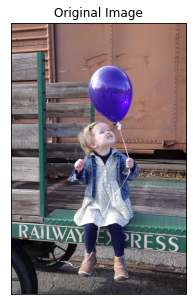

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2022-09-29 01:24:13.497222: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-09-29 01:24:13.793870: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-09-29 01:24:13.810429: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


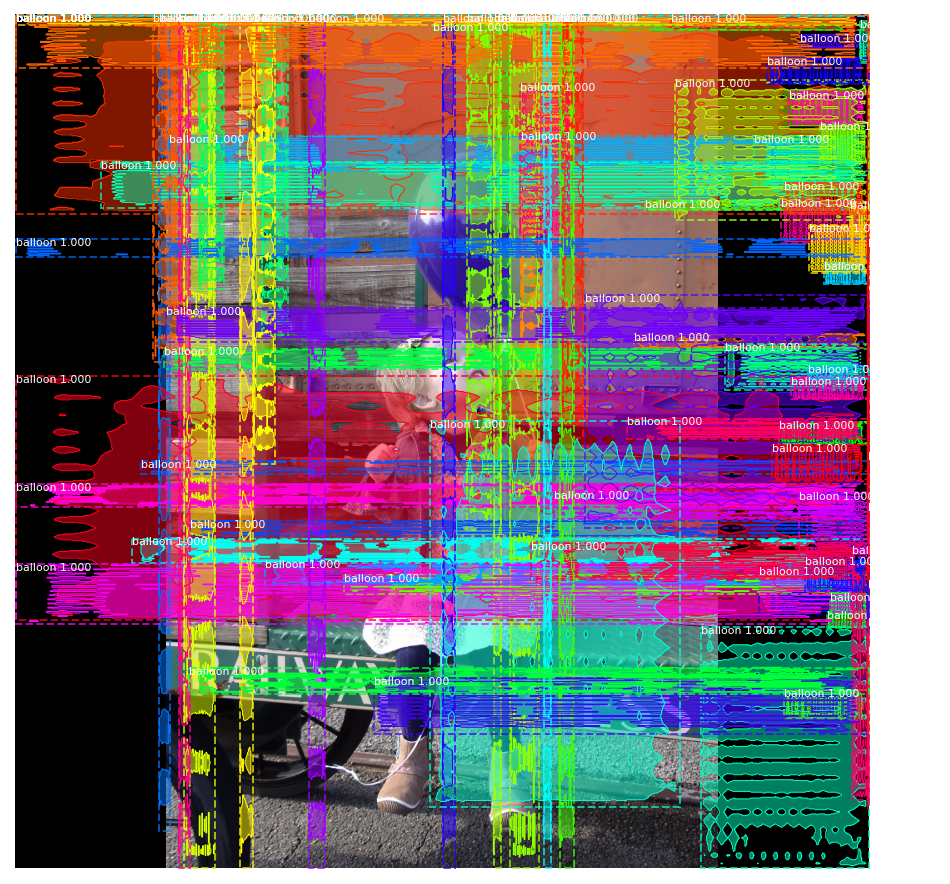

In [26]:
ind = 0
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

In [31]:
for i in dataset_val:
    print (i)
    break

TypeError: 'BalloonDataset' object is not iterable

Processing 1 images
image                    shape: (2048, 1323, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


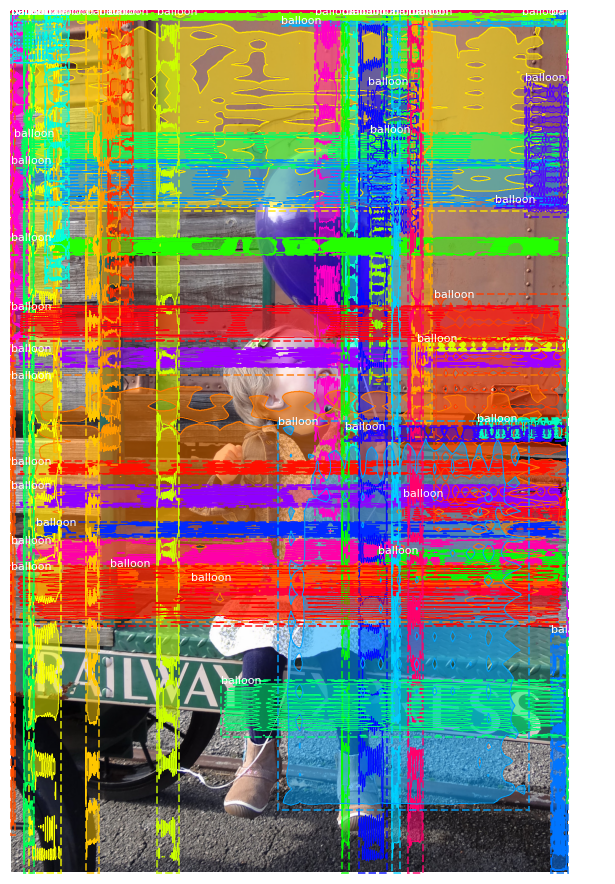

In [33]:
#image = dataset_val.load_image(ind)
import cv2

filename= '/kaggle/input/balloon/balloon/val/24631331976_defa3bb61f_k.jpg'
image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

class_names = ['BG','balloon']

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
#print (r['masks'])
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             class_names, r['scores'],title="",figsize=(16, 16), ax=None,show_mask=True, show_bbox=True)

visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=class_names, 
                                  #scores=r['scores'],
                           show_mask=True)



Processing 1 images
image                    shape: (681, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


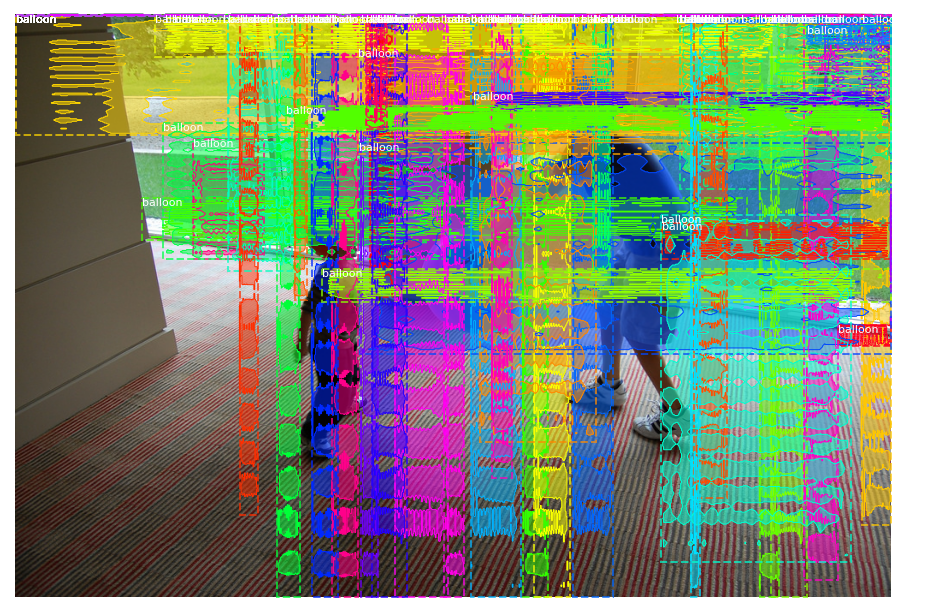

In [34]:
#image = dataset_val.load_image(ind)
import cv2

filename= '/kaggle/input/balloon/balloon/val/2917282960_06beee649a_b.jpg'
image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

class_names = ['BG','balloon']

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
#print (r['masks'])
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             class_names, r['scores'],title="",figsize=(16, 16), ax=None,show_mask=True, show_bbox=True)

visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=class_names, 
                                  #scores=r['scores'],
                           show_mask=True)

